In [25]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import xgboost as xgb
df = pd.read_csv('res_sm.csv')

variable_lable = ['金额', '退赃', '自首', '不构成自首', '坦白', '如实供述', '主动交代', '立功',
       '检举查证属实', '揭发', '立功不予采纳', '认罪态度良好', '认罪认罚', '当庭认罪', '悔罪', '多次索贿',
       '致使公共财产、国家和人民利益遭受损失', '为他人谋取职务提拔、调整', '曾因受过处分', '曾因*罪', '赃款赃物用于非法活动',
       '无法追缴', '造成恶劣影响', '造成严重后果', '通过其他国家工作人员职务上的行为']

output_lable = ['有期徒刑', '缓刑', '罚金']
output_lable = ['有期徒刑']

df.fillna(0,inplace=True)
variable = df.loc[:,variable_lable].values.astype(np.float32)
output = df.loc[:,output_lable].values.astype(np.float32)

In [26]:
feature_num = len(variable_lable)
lable_num = len(output_lable)

class Net(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.lin1 = nn.Linear(feature_num, 128)
        self.lin2 = nn.Linear(128, 16)
        self.lin3 = nn.Linear(16, lable_num)
    
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def train(self, train_loader,epoch=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        for i in range(epoch):
            for x, y in train_loader:
                y_pred = self.forward(x)
                loss = criterion(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if i%10 == 0:
                print(f'epoch:{i}, loss:{loss.item()}')

train_idx = np.random.choice(len(variable), int(len(variable)*0.8), replace=False)
test_idx = np.array(list(set(range(len(variable))) - set(train_idx)))

data_train = variable[train_idx]
lable_train = output[train_idx]
data_test = variable[test_idx]
lable_test = output[test_idx]

# train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(variable[train_idx]), torch.from_numpy(output[train_idx]))
# test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(variable[test_idx]), torch.from_numpy(output[test_idx]))

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# net = Net()

# net.train(train_loader)


969.48145 625.5042


<AxesSubplot:ylabel='Count'>

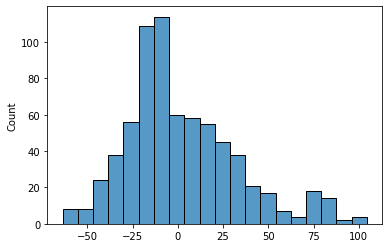

In [29]:
model = xgb.XGBRegressor(max_depth = 6, n_estimators = 1000, learning_rate = 0.01)
model.fit(data_train, lable_train)


from sklearn.metrics import mean_squared_error
pre_test = model.predict(data_test)
msetest = mean_squared_error(lable_test,pre_test)

pre_train = model.predict(data_train)
msetrain = mean_squared_error(lable_train,pre_train)

print(msetest,msetrain)


diff = lable_test.flatten()-pre_test

import seaborn as sns

sns.histplot(diff)